# Tutorial Part-of-Speech tagging  Con Deep Learning (mb-01)

### En este tutorial, veremos cómo se puede mejorar el modelo base, usando una funcion de metrica

## PARTE 1  -  Pre-Procesamiento
### Cargamos los Datos de pre-procesamiento de modelo base mb-00

In [1]:
# Asegurar reproducibilidad

import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [2]:
def to_categoricals(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [3]:
import pickle

MAX_LENGTH = 149

test_tags = []
with open("../vectors/test_tags.txt", "rb") as fp:
    test_tags = pickle.load(fp)
    
word2index = np.load('../vectors/word2index.npy').item()
tag2index  = np.load('../vectors/tag2index.npy').item()

train_sentences_X = np.load('../vectors/train_sentences_X.npy')
eval_sentences_X  = np.load('../vectors/eval_sentences_X.npy')
test_sentences_X  = np.load('../vectors/test_sentences_X.npy')

train_tags_y = np.load('../vectors/train_tags_y.npy')
eval_tags_y  = np.load('../vectors/eval_tags_y.npy')
test_tags_y  = np.load('../vectors/test_tags_y.npy')

cat_train_tags_y = to_categoricals(train_tags_y, len(tag2index))
cat_eval_tags_y  = to_categoricals(eval_tags_y, len(tag2index))
cat_test_tags_y  = to_categoricals(test_tags_y, len(tag2index))

#print (len(word2index))
#print (len(tag2index))

#print(train_sentences_X[0])
#print(eval_sentences_X[0])
#print(test_sentences_X[0])
#print(cat_train_tags_y[0])

## PARTE 2  -  Entrenamiento

In [4]:
## Funcion que permite forzar el uso de GPU cuando estan presentes

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [6]:
#!conda install -c conda-forge keras -y
!pip install keras
from keras import backend as K
 
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

ModuleNotFoundError: No module named 'keras'

### Definimos el Modelo Base con el cual se procedera a desarrollar la fase de Entrenamiento

In [24]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Embedding, Activation
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(Embedding(len(word2index), 128))
model.add(Activation('relu'))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy', ignore_class_accuracy(0)])
 
model.summary()

plot_model(model, to_file='../Plot/model/model-mb01.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 149, 128)          3135872   
_________________________________________________________________
activation_5 (Activation)    (None, 149, 128)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 149, 291)          37539     
_________________________________________________________________
activation_6 (Activation)    (None, 149, 291)          0         
Total params: 3,173,411
Trainable params: 3,173,411
Non-trainable params: 0
_________________________________________________________________


### Se dedarrolla el entrenamiento del modelo

In [25]:
#sudo pip install h5py
import os
model_hist = model.fit(train_sentences_X, cat_train_tags_y,
                       validation_data=(eval_sentences_X, cat_eval_tags_y),
                       batch_size=128, 
                       epochs=40,
                       validation_split=0.2)

# serialize model to JSON
model_json = model.to_json()
with open("../model/mb-01.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("../model/mb-01.h5")
print("Saved model to disk")

Train on 3618 samples, validate on 1206 samples
Epoch 1/40
3618/3618 [==============================] - 2s 589us/step - loss: 5.5919 - acc: 0.4478 - ignore_accuracy: 0.2735 - val_loss: 5.4642 - val_acc: 0.9057 - val_ignore_accuracy: 0.5624
Epoch 2/40
3618/3618 [==============================] - 2s 501us/step - loss: 5.3055 - acc: 0.9095 - ignore_accuracy: 0.5759 - val_loss: 5.0881 - val_acc: 0.9097 - val_ignore_accuracy: 0.5808
Epoch 3/40
3618/3618 [==============================] - 2s 510us/step - loss: 4.8100 - acc: 0.9117 - ignore_accuracy: 0.5862 - val_loss: 4.4445 - val_acc: 0.9093 - val_ignore_accuracy: 0.5791
Epoch 4/40
3618/3618 [==============================] - 2s 504us/step - loss: 4.0170 - acc: 0.9099 - ignore_accuracy: 0.5778 - val_loss: 3.4863 - val_acc: 0.9064 - val_ignore_accuracy: 0.5658
Epoch 5/40
3618/3618 [==============================] - 2s 526us/step - loss: 2.9288 - acc: 0.9108 - ignore_accuracy: 0.5825 - val_loss: 2.2933 - val_acc: 0.9114 - val_ignore_accuracy:

## PARTE 3  -  Evaluación del Modelo

### Evaluamos el modelo y calculamos el valor de precision con respecto a los datos de prueba

In [26]:
scores = model.evaluate(test_sentences_X, cat_test_tags_y)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   # acc: 97.66269326210022

1206/1206 [==============================] - 0s 232us/step
acc: 96.76616860068656


### Definimos la funcion que nos servira para graficar el comportamiento del modelo en cada epoca del entrenamiento

In [27]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
    
    fig.savefig('../Plot/training/training-mb-01.png', bbox_inches='tight')

### Procedemos a Graficar el comportamiento del Entrenamiento, tanto del conjunto de entrenamiento como el de validación con respecto a la cantidad de epocas

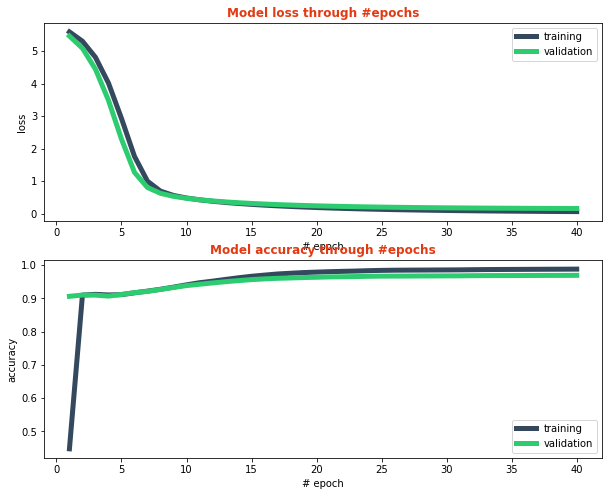

In [28]:
plot_model_performance(
    train_loss=model_hist.history.get('loss', []),
    train_acc=model_hist.history.get('acc', []),
    train_val_loss=model_hist.history.get('val_loss', []),
    train_val_acc=model_hist.history.get('val_acc', [])
)

### Función que Permite convertir Indices en Tags

In [29]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

### Hacemos la prediccion sobre el conjunto de pruebas 

In [30]:
import pandas as pd

prediction = model.predict(test_sentences_X)
log_tokens = logits_to_tokens(prediction, {i: t for t, i in tag2index.items()})

print(log_tokens[0])

['da0ms0', 'ncms000', 'aq0cs0', 'vaip3s0', 'vmp00sm', 'pr0cn000', 'da0fs0', 'ncfs000', 'sps00', 'ncfs000', 'vaip3s0', 'vmp00sm', 'sps00', 'Fe', 'vmn0000', 'Fe', 'Fc', 'cc', 'sn.e-SUJ', 'vaip3s0', 'ncfs000', 'pr0cn000', 'da0ms0', 'ncms000', 'sps00', 'da0ms0', 'ncms000', 'vmip3s0', 'pr0cn000', 'sps00', 'da0ms0', 'np0000l', 'Fe', 'di0mp0', 'vmip3p0', 'sps00', 'da0fs0', 'di0fs0', 'ncfs000', 'Fe', 'Fp', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PA

### Hallamos los valores de F1 score, recall, precision

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

results = pd.DataFrame(columns=['Expected', 'Predicted'])
k = 0
for i, lista_etiquetas_oracion in enumerate(test_tags):
    for j, etiquetas in enumerate(lista_etiquetas_oracion):
        k = k + 1
        results.loc[k, 'Expected'] = etiquetas
        results.loc[k, 'Predicted'] = log_tokens[i][j]

# print(results)


print('\nclassification_report:\n', classification_report(results['Expected'], results['Predicted']))

/home/deep-learning/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/deep-learning/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



classification_report:
               precision    recall  f1-score   support

       -PAD-       0.00      0.00      0.00         0
         Faa       0.00      0.00      0.00         2
         Fat       0.00      0.00      0.00         5
          Fc       1.00      1.00      1.00      2291
          Fd       1.00      1.00      1.00        87
          Fe       1.00      1.00      1.00       631
          Fg       1.00      1.00      1.00       226
          Fh       0.00      0.00      0.00         3
         Fia       1.00      1.00      1.00         6
         Fit       1.00      1.00      1.00        19
          Fp       1.00      1.00      1.00      1178
         Fpa       1.00      1.00      1.00       156
         Fpt       1.00      1.00      1.00       160
          Fs       0.00      0.00      0.00        13
          Fx       1.00      1.00      1.00        41
          Fz       0.00      0.00      0.00         2
           W       0.98      0.61      0.76       194
  

## PARTE 4  -  Testing

### Creamos un pequeño Ejemplo

In [32]:
test_samples = [
    "Correr es importante para mi .".split(),
    "El hombre bajo corre bajo el puente con bajo índice de adrenalina .".split()
]
print(test_samples)

[['Correr', 'es', 'importante', 'para', 'mi', '.'], ['El', 'hombre', 'bajo', 'corre', 'bajo', 'el', 'puente', 'con', 'bajo', 'índice', 'de', 'adrenalina', '.']]


### Convertimos el texto en Una entrada para el Modelo

In [34]:
from keras.preprocessing.sequence import pad_sequences

test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[21101 19732 15398  3001  8200 10350     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [11516  4297 24354 12735 24354 11516  1977  2248 24354 20545 19988     1
  103

### Se Ejecuta la predicion con la Entrada del modelo entrenado

In [35]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[6.9912414e-05 1.9035535e-05 1.7608612e-04 ... 9.3049704e-05
   4.4171789e-05 8.4772467e-04]
  [3.1409949e-05 3.3023778e-07 1.8924775e-05 ... 9.2923729e-06
   6.5194990e-07 4.1093995e-06]
  [3.8044902e-06 1.3886270e-07 4.2133238e-06 ... 3.4761397e-06
   1.0615811e-06 4.7008311e-06]
  ...
  [9.9707603e-01 6.2639297e-06 1.2724652e-05 ... 1.4723864e-05
   1.0373007e-05 1.8721856e-05]
  [9.9707603e-01 6.2639297e-06 1.2724652e-05 ... 1.4723864e-05
   1.0373007e-05 1.8721856e-05]
  [9.9707603e-01 6.2639297e-06 1.2724652e-05 ... 1.4723864e-05
   1.0373007e-05 1.8721856e-05]]

 [[6.5965000e-06 3.0543850e-07 3.5262690e-06 ... 1.9677891e-05
   1.4603849e-06 5.4208726e-06]
  [3.9042014e-05 1.6624225e-06 1.0626204e-05 ... 1.7323964e-05
   4.1576318e-06 1.5153269e-04]
  [1.5270970e-04 4.5445770e-05 3.6536402e-04 ... 5.6106055e-05
   1.0471978e-04 1.5815722e-03]
  ...
  [9.9707603e-01 6.2639297e-06 1.2724652e-05 ... 1.4723864e-05
   1.0373007e-05 1.8721856e-05]
  [9.9707603e-01 6.2639297e-06 1.272

### Conversion de la Salida del Modelo a un lista de Indices de Tags

In [36]:
#print(len(predictions))
log_tokens = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
print(log_tokens)

[['vmn0000', 'vsip3s0', 'aq0cs0', 'sps00', 'dp1css', 'Fp', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD

### Presentación de los Resultados

In [37]:
#!pip install tabulate
from tabulate import tabulate

heads1 = test_samples[0]
body1 = [log_tokens[0][:len(test_samples[0])]]

heads2 = test_samples[1]
body2 = [log_tokens[1][:len(test_samples[1])]]

print(tabulate(body1, headers=heads1))

print ("\n")

print(tabulate(body2, headers=heads2))


## postagging Freeling 4.1

## El      hombre   bajo     corre    bajo  el      puente   con  bajo  índice   de  adrenalina  .
## DA0MS0  NCMS000  AQ0MS00  VMIP3S0  SP    DA0MS0  NCMS000  SP   SP    NCMS000  SP  NCFS000     Fp


## pos tagger Stanford NLP

## El      hombre   bajo     corre    bajo  el      puente   con    bajo   índice  de    adrenalina  .
## da0000  nc0s000  aq0000   vmip000  sp000 da0000  nc0s000  sp000  aq0000 nc0s000 sp000 nc0s000     fp

Correr    es       importante    para    mi      .
--------  -------  ------------  ------  ------  ---
vmn0000   vsip3s0  aq0cs0        sps00   dp1css  Fp


El      hombre    bajo    corre    bajo    el      puente    con    bajo    índice    de     adrenalina    .
------  --------  ------  -------  ------  ------  --------  -----  ------  --------  -----  ------------  ---
da0ms0  ncms000   sps00   vmip3s0  sps00   da0ms0  ncms000   sps00  sps00   ncms000   sps00  ncms000       Fp
